In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional,\
                      GRU, Dropout,GlobalAveragePooling1D, Conv1D, TimeDistributed,\
                      Input, Concatenate, GlobalMaxPooling1D
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import re
from nltk import sent_tokenize, word_tokenize, pos_tag, ne_chunk
import nltk.data
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
from nltk.chunk.util import ChunkScore
import pickle
import math
#import collections.Iterable as Iterable

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from nltk.chunk import conlltags2tree, tree2conlltags

import gzip
from lxml import etree
from tqdm import tqdm
import random
from collections import Counter

%load_ext autoreload
%autoreload 2
import os, inspect, sys
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from unwiki import unwiki
import ner
from embed_utils import open_w2v
import clean_and_token_text as clean

In [2]:
#with open('/media/hd1/wikipedia/wiki_definitions_improved.txt', 'r') as wiki_f:
#    wiki = wiki_f.readlines()

cfg = {}

wiki = []
with gzip.open('/media/hd1/wikipedia/wiki_definitions_improved.xml.gz', 'r') as xml_fobj:
    def_xml = etree.parse(xml_fobj)
    for art in def_xml.findall('definition'):
        data = (art.find('.//dfndum').text, '', art.find('.//stmnt').text)
        wiki.append(data)

# Get data and train the Sentence tokenizer
# Uses a standard algorithm (Kiss-Strunk) for unsupervised sentence boundary detection
text = ''
for i in range(3550):
    text += wiki[i][2]

trainer = PunktTrainer()
trainer.INCLUDE_ALL_COLLOCS = True
trainer.train(text)
sent_tok = PunktSentenceTokenizer(trainer.get_params())
print(sent_tok._params.abbrev_types)

def_lst = ner.bio_tag.put_pos_ner_tags(wiki, sent_tok)

# Finding the POS set 
pos_cnt = Counter()
for Def in def_lst:
    pos_cnt.update([el[0][1] for el in Def['ner']])
print("Found {} alphanum POS tags in the data, the most common are: {}"\
      .format(len(pos_cnt), pos_cnt.most_common()[:10]))
pos_lst = list(pos_cnt)
pos_ind_dict = {pos: k for k, pos in enumerate(pos_lst)}

{'ed', 'hrc', 'subpopulation', 'a.s', 'z-1', 'a.k.a', 'm.n', 's.p.r.l', "'if", 'viz', 'rum', 'ie', 'gov', 'p.o.a', 'oct', 'dha', 'happiness', 'a.d', 'm-m', 's1', 'anomalies', 'crinem', 's^2', 'p.h.d', 'u.n', 'ginebra', 'a.i', 'eng', 'ts2', 'ifc', 'tov', 'j.w', 'c.s', 'u.s.c', 'u.s', 'sas', 'jr', 'i.w.w', 'i.d', 'k.c', 'qom', 'nsb', 'al', 'p.m', 's.c', 'aff', 'fins', 'spacewalks', 'o.s.m', 'c.w', 'w.b', 'i.e', 'j.c', 'ltd', 'f.h', '15b', '2a', 'r/m', 'pdi', 'exhibition', 'sow', 'jie', 'c6an', 'gta', 'az', 'm4', 'b-1', 'ye', 'j.d', '1949.03631mm', 'etc', 'x+2', 'rv', 's.r', 'ph.d', 'acb', 'i.i.d', 'n.b', 'd1', 'orb', 's.t', 'technician', '|c|', 'p.12', 'q.v', 'fig', 'resp', 'fn', 'r.a', 'nfa', 'b.k.s', 'vs', 'soc', 'rim', 'g.i', "'up", 'np5', 'cf', 'exe', 'pt', 'j.m', 'e.g', 'juniper', 'pl'}
Found 45 alphanum POS tags in the data, the most common are: [('NN', 83732), ('IN', 53527), ('DT', 49629), ('JJ', 41431), ('NNP', 30113), ('NNS', 25080), (',', 21585), ('VBZ', 17595), ('CC', 13971), 

In [3]:
with open_w2v('/media/hd1/embeddings/model4ner_19-33_02-01/vectors.bin') as embed_dict:
    wind = ['<UNK>',] + list(embed_dict.keys())
    cfg['emb_nvocab'] = len(wind) 
    embed_matrix = np.zeros((cfg['emb_nvocab'], 200))
    for word, vec in embed_dict.items():
        #vect = embed_dict.get(word)
        ind = wind.index(word)
            #vect = vect/np.linalg.norm(vect)
        embed_matrix[ind] = vec
#print("Coverage of embed is: {}".format(coverage_cnt/len(embed_dict)))

Vocabulary size: 208442 and dimension of embed: 200


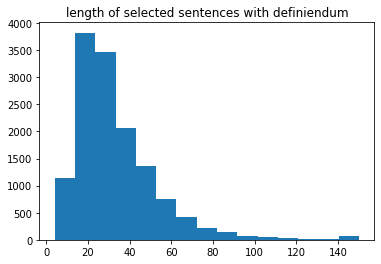

In [4]:
sent_lengths = []
for d in def_lst:
    slen = min(len(d['ner']), 150)
    sent_lengths.append(slen)
plt.hist(sent_lengths, bins=15)
plt.title('length of selected sentences with definiendum')
plt.show()

In [5]:
cfg['padseq'] = {'maxlen': 50 , 'padding': 'post', 'truncating': 'post'}
cfg['n_tags'] = 2

# shuffle def_lst
random.shuffle(def_lst)

cfg['train_test_split'] = 0.8

train_def_lst = def_lst[:int(cfg['train_test_split']*len(def_lst))]
test_def_lst = def_lst[int(cfg['train_test_split']*len(def_lst)):]

def prep_data(dat, wind, cfg, *args):
    '''
   dat should be in the "ner" format
    '''
    if isinstance(dat, str):
        dat_tok = word_tokenize(dat)
        norm_words = [clean.normalize_text(d).strip() for d in dat_tok]
        labels = [False for d in dat]
    else:
        norm_words = [clean.normalize_text(d[0][0]).strip() for d in dat]
        labels = [d[1] != 'O' for d in dat]
    ind_words = []
    for w in norm_words:
        try:
            ind_words.append(wind.index(w))
        except ValueError:
            ind_words.append(0)
    return ind_words, labels

def prep_pos(dat, pos_ind_dict):
    '''
    dat is in the format:
    [(('In', 'IN'), 'O'),
     (('Southern', 'NNP'), 'O'),
     (('Africa', 'NNP'), 'O'),
     ((',', ','), 'O'),
     (('the', 'DT'), 'O'),
     (('word', 'NN'), 'O')]
    '''
    out_lst = []
    for d in dat:
        out_lst.append(pos_ind_dict[d[0][1]])
    return out_lst

train_data = [prep_data(d['ner'], wind, cfg) for d in train_def_lst]
train_seq, train_lab = zip(*train_data)
train_pos_seq = [prep_pos(d['ner'], pos_ind_dict) for d in train_def_lst]
train_seq = pad_sequences(train_seq, **cfg['padseq'])
train_pos_seq = pad_sequences(train_pos_seq, **cfg['padseq'])
train_lab = pad_sequences(train_lab, **cfg['padseq'])
#train_lab = np.array([to_categorical(s, num_classes=cfg['n_tags']) for s in train_lab])

test_data = [prep_data(d['ner'], wind, cfg) for d in test_def_lst]
test_seq, test_lab = zip(*test_data)
test_pos_seq = [prep_pos(d['ner'], pos_ind_dict) for d in test_def_lst]
test_seq = pad_sequences(test_seq, **cfg['padseq'])
test_pos_seq = pad_sequences(test_pos_seq, **cfg['padseq'])
test_lab = pad_sequences(test_lab, **cfg['padseq'])
#test_lab = np.array([to_categorical(s, num_classes=cfg['n_tags']) for s in test_lab])

### TODO
* Search for a minimal stemmer that strips plural or adverbial suffices for example zero-sum games in zero-sum game or absolute continuity and absolute continuous

In [37]:
class NerModel(tf.keras.Model):
    def __init__(self, hidden_num, vocab_size, label_size, embedding_size):
        super(NerModel, self).__init__()
        self.hidden_num = hidden_num
        self.vocab_size = vocab_size
        self.label_size = label_size
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.biLSTM = Bidirectional(LSTM(hidden_num, return_sequences=True))
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.dense = Dense(label_size)
        
        self.transition_params = tf.Variable(tf.random.uniform(shape=(label_size, label_size)))
        
    def call(self, text, labels=None, training=None):
        text_lens = tf.math.reduce_sum(tf.cast(tf.math.not_equal(text, 0), dtype=tf.int32), axis=-1)
        inputs = self.embedding(text)
        inputs = self.biLSTM(inputs)
        inputs = self.dropout(inputs, training)
        logits = self.dense(inputs)
        
        if labels is not None:
            label_sequences = tf.convert_to_tensor(labels, dtype=tf.int32)
            log_likelihood, self.transition_params = \
            tfa.text.crf_log_likelihood(logits, label_sequences, text_lens,
                                        transition_params=self.transition_params)
            return logits, text_lens, log_likelihood
        else:
            return logits, text_lens
        
#model.summary()

In [38]:
# Train NER model
cfg['learning_rate'] = 0.1
model = NerModel(64, len(word_tok.word_index)+1, 4, 100)
optimizer = tf.keras.optimizers.Adam()
def train_one_step(text_batch, labels_batch):
    with tf.GradientTape() as tape:
        logits, text_lens, log_likelihood = model(text_batch, labels_batch, training=True)
        loss = - tf.reduce_mean(log_likelihood)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, logits, text_lens

def get_acc_one_step(logits, text_lens, labels_batch):
    paths = []
    accuracy = 0
    for logit, text_len, labels in zip(logits, text_lens, labels_batch):
        viterbi_path, _ = tfa.text.viterbi_decode(logit[:text_len], model.transition_params)
        paths.append(viterbi_path)
        correct_prediction = tf.equal(
            tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([viterbi_path],
                                                            padding='post'), dtype=tf.int32),
            tf.convert_to_tensor(tf.keras.preprocessing.sequence.pad_sequences([labels[:text_len]],
                                                            padding='post'), dtype=tf.int32)
        )
        accuracy = accuracy + tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        # print(tf.reduce_mean(tf.cast(correct_prediction, tf.float32)))
    accuracy = accuracy / len(paths)
    return accuracy

best_acc = 0
step = 0
epochs = 20
bs = 1000
for epoch in range(epochs):
    for (text_batch, labels_batch) in \
    [[train_seq2[bs*i:bs*(i+1)], train_lab2[bs*i:bs*(i+1)]]\
     for i in range(math.ceil(len(train_seq2)/bs))]:
        step = step + 1
        loss, logits, text_lens = train_one_step(text_batch, labels_batch)
        if step % 20 == 0:
            accuracy = get_acc_one_step(logits, text_lens, labels_batch)
            print('epoch %d, step %d, loss %.4f , accuracy %.4f' % (epoch, step, loss, accuracy))
            if accuracy > best_acc:
                best_acc = accuracy
                #ckpt_manager.save()
                print("model saved")

Instructions for updating:
Use tf.identity instead.
epoch 1, step 20, loss 14.9342 , accuracy 0.8911
model saved
epoch 3, step 40, loss 7.0272 , accuracy 0.9495
model saved
epoch 5, step 60, loss 5.6116 , accuracy 0.9628
model saved
epoch 7, step 80, loss 4.2118 , accuracy 0.9717
model saved
epoch 9, step 100, loss 4.0879 , accuracy 0.9750
model saved
epoch 10, step 120, loss 4.2285 , accuracy 0.9665
epoch 12, step 140, loss 3.8653 , accuracy 0.9675
epoch 14, step 160, loss 3.1836 , accuracy 0.9706
epoch 16, step 180, loss 3.0588 , accuracy 0.9720
epoch 18, step 200, loss 2.4088 , accuracy 0.9749
epoch 19, step 220, loss 2.1086 , accuracy 0.9771
model saved


In [39]:
model.summary()

Model: "ner_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  4208400   
_________________________________________________________________
bidirectional (Bidirectional multiple                  84480     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  516       
Total params: 4,293,412
Trainable params: 4,293,412
Non-trainable params: 0
_________________________________________________________________


In [8]:
sample_str = 'A banach space is defined as named entity recognition'
sample_tok = word_tok.texts_to_sequences([sample_str])
sample_pad = pad_sequences(sample_tok, maxlen=cfg['maxlen'], padding=cfg['padding'])
pred = [model.predict(text_batch[i])[1] for i in range(len(text_batch))]

NameError: name 'word_tok' is not defined

In [7]:
cfg.update({'input_dim': len(wind),
      'output_dim': 200,
     'input_length': cfg['padseq']['maxlen'],
     'pos_dim': 5,
     'n_tags': 2,
     'batch_size': 1000,
     'lstm_units': 150,
      'adam': {'lr': 0.05, 'beta_1': 0.9, 'beta_2': 0.999}})

In [56]:
def bilstm_lstm_model_w_pos(cfg_dict):
    
    words_in = Input(shape=(cfg_dict['input_length'], ))
    pos_in = Input(shape=(cfg_dict['input_length'], ))
    #capitalized = Input(shape=(1,), name='capitalized')
    
    word_embed = Embedding(cfg_dict['input_dim'], 
                        output_dim=cfg_dict['output_dim'],
                        input_length=cfg_dict['input_length'],
                       weights = [embed_matrix],
                       trainable = False,
                          name='word-embed')(words_in)
    pos_embed = Embedding(len(pos_cnt), 
                        output_dim=cfg_dict['pos_dim'],
                        input_length=cfg_dict['input_length'],
                       trainable = True,
                         name='pos-embed')(pos_in)
    full_embed = Concatenate(axis=2)([word_embed, pos_embed])
    
    
    out = Bidirectional(LSTM(units=cfg['lstm_units'],
                                 return_sequences=True,
                                 dropout=0.2, 
                                 recurrent_dropout=0.2),
                        merge_mode = 'concat')(full_embed)
    #out = GlobalMaxPooling1D(out) 
    # Add LSTM
    out = Bidirectional(LSTM(units=cfg['lstm_units'],
                   return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
                   recurrent_initializer='glorot_uniform'),
                        merge_mode = 'concat')(out)
    # Add timeDistributed Layer
    out = TimeDistributed(Dense(10, activation="relu"))(out)
    out = TimeDistributed(Dense(1, activation="sigmoid"))(out)
    #Optimiser 
    adam = Adam(**cfg['adam'])
    # Compile model
    bce = tf.keras.losses.BinaryCrossentropy()  #(sample_weight=[0.3, 0.7])
    model = Model([words_in, pos_in], out)
    model.compile(loss = bce,   #'binary_crossentropy',
                  optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model
with_pos = bilstm_lstm_model_w_pos(cfg)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 50)]         0                                            
__________________________________________________________________________________________________
word-embed (Embedding)          (None, 50, 200)      41688600    input_13[0][0]                   
__________________________________________________________________________________________________
pos-embed (Embedding)           (None, 50, 5)        225         input_14[0][0]                   
____________________________________________________________________________________________

In [27]:
res = with_pos.fit([train_seq, train_pos_seq], train_lab, verbose=1, epochs=70,
                batch_size=cfg['batch_size'],
                validation_data=([test_seq, test_pos_seq], test_lab))

Epoch 1/70
11/11 [==============================] - 4s 366ms/step - loss: 0.3141 - accuracy: 0.9341 - val_loss: 0.1402 - val_accuracy: 0.9606
Epoch 2/70
11/11 [==============================] - 4s 331ms/step - loss: 0.1266 - accuracy: 0.9608 - val_loss: 0.1153 - val_accuracy: 0.9606
Epoch 3/70
11/11 [==============================] - 4s 330ms/step - loss: 0.1094 - accuracy: 0.9608 - val_loss: 0.1030 - val_accuracy: 0.9606
Epoch 4/70
11/11 [==============================] - 4s 333ms/step - loss: 0.0979 - accuracy: 0.9608 - val_loss: 0.0916 - val_accuracy: 0.9606
Epoch 5/70
11/11 [==============================] - 4s 333ms/step - loss: 0.0881 - accuracy: 0.9608 - val_loss: 0.0837 - val_accuracy: 0.9606
Epoch 6/70
11/11 [==============================] - 4s 329ms/step - loss: 0.0814 - accuracy: 0.9608 - val_loss: 0.0784 - val_accuracy: 0.9606
Epoch 7/70
11/11 [==============================] - 4s 331ms/step - loss: 0.0759 - accuracy: 0.9608 - val_loss: 0.0746 - val_accuracy: 0.9606
Epoch 

In [7]:
# DEFINE MODEL WITH biLSTM AND TRAIN FUNCTION    
def get_bilstm_lstm_model(cfg_dict):
    model = Sequential()
    # Add Embedding layer
    model.add(Embedding(cfg_dict['input_dim'], 
                        output_dim=cfg_dict['output_dim'],
                        input_length=cfg_dict['input_length'],
                       weights = [embed_matrix],
                       trainable = False))
    #model.add(Embedding(cfg_dict['input_dim'], 
    #                    output_dim=cfg_dict['output_dim'],
    #                    input_length=cfg_dict['input_length']))
    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=cfg_dict['output_dim'],
                                 return_sequences=True,
                                 dropout=0.2, 
                                 recurrent_dropout=0.2), merge_mode = 'concat'))
    # Add LSTM
    model.add(LSTM(units=cfg_dict['output_dim'],
                   return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
                   recurrent_initializer='glorot_uniform'))
    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(1, activation="sigmoid")))
    #Optimiser 
    adam = Adam(**cfg['adam'])
    # Compile model
    #bce = tf.keras.losses.BinaryCrossentropy(sample_weight=[0.3, 0.7])
    model.compile(loss = 'binary_crossentropy',
                  optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model


def train_model(X, y, model, epochs=10):
    # fit model for one epoch on this sequence
    res = model.fit(X, y, verbose=0, epochs=epochs,
                    batch_size=cfg['batch_size'],
                    validation_data=(test_seq, test_lab),
                   callbacks=[TqdmCallback(verbose=1)])
                   
    return res
model_bilstm_lstm = get_bilstm_lstm_model(cfg)
#plot_model(model_bilstm_lstm)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 200)           41688600  
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 400)           641600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 200)           480800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 1)             201       
Total params: 42,811,201
Trainable params: 1,122,601
Non-trainable params: 41,688,600
_________________________________________________________________


In [71]:
history = train_model(train_seq, train_lab, model_bilstm_lstm, epochs=20)

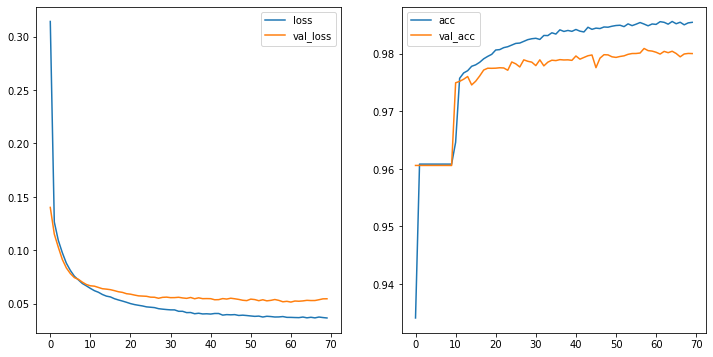

In [28]:
#r = history
r = res
fig = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
ax1.plot(r.history['loss'], label='loss')
ax1.plot(r.history['val_loss'], label='val_loss')
ax1.legend()
ax2 = plt.subplot(122)
ax2.plot(r.history['accuracy'], label='acc')
ax2.plot(r.history['val_accuracy'], label='val_acc')
ax2.legend()

In [104]:
#sample_str = 'a banach space is defined as complete vector space of some kind .'
#sample_str = 'We define a shushu space as a complete vector space of some kind .'
sample_str = '_display_math_ The Ursell functions of a single random variable X are obtained from these by setting _inline_math_..._inline_math_ .'
sample_pad, _ = prep_data(sample_str, wind, cfg, 'no_tags')
sample_pad = pad_sequences([sample_pad], **cfg['padseq'])
pred = model_bilstm_lstm.predict(sample_pad)
#np.argmax(pred.squeeze(), axis=1)
for i, w in enumerate(sample_pad[0]):
    if wind[w] == '.':
        break
    print(wind[w], np.round(pred)[0][i])
    if wind[w] == '.':
        break

NameError: name 'model_bilstm_lstm' is not defined

In [29]:
#preds = model_bilstm_lstm.predict(test_seq)
preds = with_pos.predict([test_seq, test_pos_seq])

In [44]:
k = 283
for i in range(len(preds[k])):
    try:
        print('{:<20} {} {:1.2f}'.format(test_def_lst[k]['ner'][i][0][0], 
                                         test_def_lst[k]['ner'][i][1],
                                         round(preds[k][i][0],2)))
    except IndexError:
        break

If                   O 0.00
the                  O 0.00
relationship         O 0.00
between              O 0.00
values               O 0.00
of                   O 0.00
_inline_math_        O 0.00
and                  O 0.00
values               O 0.00
of                   O 0.00
_inline_math_        O 0.00
is                   O 0.00
linear               O 0.01
(                    O 0.00
which                O 0.00
is                   O 0.00
certainly            O 0.00
true                 O 0.00
when                 O 0.00
there                O 0.00
are                  O 0.00
only                 O 0.00
two                  O 0.00
possibilities        O 0.00
for                  O 0.00
x                    O 0.00
)                    O 0.00
this                 O 0.00
will                 O 0.00
give                 O 0.00
the                  O 0.00
same                 O 0.00
result               O 0.00
as                   O 0.00
the                  O 0.00
square              

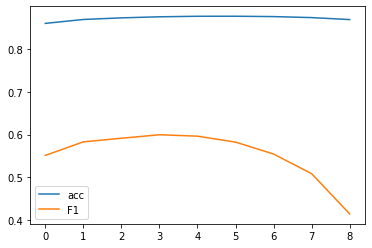

ChunkParse score:
    IOB Accuracy:  87.5%%
    Precision:     59.5%%
    Recall:        60.4%%
    F-Measure:     60.0%%
Cutoff:  0.4


In [54]:
def tf_bio_tagger(tf_pred, tag_def='DFNDUM', tag_o = 'O'):
    '''
    Convert a T/F (binary) Sequence into a BIO tag sequence
    [True, False, False] -> [B-DFNDUM, O, O]
    '''
    begin_tag = 'B-' + tag_def
    inside_tag = 'I-' + tag_def
    out_tag = tag_o
    return_tags = []
    for ind, x in enumerate(tf_pred):
        if x:
            if ind > 0:
                ret = inside_tag if tf_pred[ind - 1] else begin_tag
                return_tags.append(ret)
            else:
                return_tags.append(begin_tag)
        else:
            return_tags.append(out_tag)
    return return_tags
        
def switch_to_pred(test_def_lst, preds, cutoff = 0.5):
    #if len(preds.shape) == 2:
        #case just one prediction (50, 1) 
    #    preds = [preds]
    out_lst = []
    for k, pred in enumerate(preds):
        tf_pred = (pred > cutoff)
        test_def = test_def_lst[k]['ner']
        bio_pred = tf_bio_tagger(tf_pred)
        switched_def_lst = []
        for i in range(len(bio_pred)):    #rate(bio_pred):
            try:
                # test_def[i] example: (('Fock', 'NNP'), 'B-DFNDUM')
                tok_pos = test_def[i][0]
                switched_def_lst.append((tok_pos, bio_pred[i]))
            except IndexError:
                break
        out_lst.append(switched_def_lst)
    return out_lst

def get_chunkscore(CutOFF):
    test_pred_lst = switch_to_pred(test_def_lst, preds, cutoff=CutOFF)
    unpack = lambda l: [(tok, pos, ner) for ((tok, pos), ner) in l]
    Tree_lst_gold = [conlltags2tree(unpack(t['ner'])) for t in test_def_lst]
    Tree_lst_pred = [conlltags2tree(unpack(t)) for t in test_pred_lst]

    chunkscore = ChunkScore()
    for i in range(len(Tree_lst_gold)):
        chunkscore.score(Tree_lst_gold[i], Tree_lst_pred[i])
    return chunkscore
 
#CutOFF = 0.4
#print(get_chunkscore(CutOFF))
#print(f"Cutoff:  {CutOFF}")

data_points = []
BOY_f_score = (0, 0) # (CutOff, score)
for co in np.arange(0.1, 1, 0.1):
    cs = get_chunkscore(co)
    data_points.append((cs.accuracy(), cs.f_measure()))
    if cs.f_measure() > BOY_f_score[1]:
        BOY_f_score = (co, cs.f_measure())

plt.plot(list(zip(*data_points))[0], label='acc')
plt.plot(list(zip(*data_points))[1], label='F1')
plt.legend()
plt.show()

print(get_chunkscore(BOY_f_score[0]))
print(f"Cutoff:  {BOY_f_score[0]}")

In [64]:
# Compute the Loss independently
bce = tf.keras.losses.BinaryCrossentropy(label_smoothing=0)
bce([1.0,0.0,1.0], [1.0,0.0,1.0]).numpy()

-0.0

In [70]:
#1/5404.0*(np.sum(test_lab*np.log(np.squeeze(preds))) + np.sum((1-test_lab)*np.log(np.squeeze(1-preds))))

-1.607125580773316

# get_bilstm_lstm_model Training history
## First working attempt:  commit e4c41f0

Epochs: 70 [01:00<00:00, 3.00s/epoch, loss=0.0513, accuracy=0.98, val_loss=0.0636, val_accuracy=0.975]

* Same attempt but first ChunkScore Epochs: approx 80,  commit: 8a3678c
        ChunkParse score:
            IOB Accuracy:  86.3%%
            Precision:     56.4%%
            Recall:        53.8%%
            F-Measure:     55.1%%
            
## Working attempt with POS: Epochs: 70
    ChunkParse score:
        IOB Accuracy:  85.4%%
        Precision:     53.2%%
        Recall:        47.6%%
        F-Measure:     50.3%%
### Added both LSTMs Bidirectional:
In the previous models the second LSTM layer was not Bidirectional. This makes no sense
loss: 0.0446 - accuracy: 0.9824 - val_loss: 0.0601 - val_accuracy: 0.9770 commit: c53ab68

    ChunkParse score:
        IOB Accuracy:  85.1%%
        Precision:     48.7%%
        Recall:        62.8%%
        F-Measure:     54.9%%
        
With just 150 lstm units. Commit: 53dd596

    ChunkParse score:
        IOB Accuracy:  87.7%%
        Precision:     61.4%%
        Recall:        62.3%%
        F-Measure:     61.8%%
    Cutoff:  0.4
    
with 

In [58]:
cfg

{'padseq': {'maxlen': 50, 'padding': 'post', 'truncating': 'post'},
 'n_tags': 2,
 'train_test_split': 0.8,
 'input_dim': 208443,
 'output_dim': 200,
 'input_length': 50,
 'pos_dim': 5,
 'batch_size': 1000,
 'adam': {'lr': 0.05, 'beta_1': 0.9, 'beta_2': 0.999}}

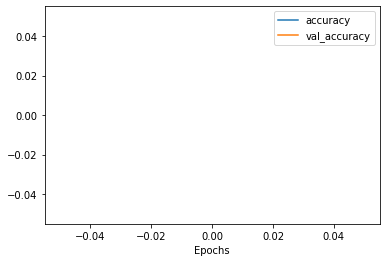

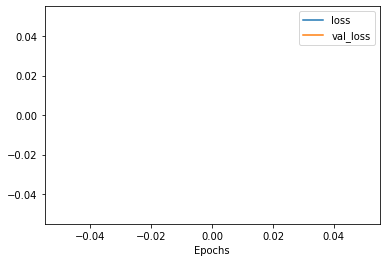

In [47]:
def plot_graphs(history, string, start_at=0):
    plt.plot(history[string][start_at:])
    plt.plot(history['val_'+string][start_at:])
    plt.xlabel('Epochs')
    plt.ylabel(string[start_at:])
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, "accuracy", start_at=400)
plot_graphs(history, "loss", start_at=400)